In [2]:
from keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) =  boston_housing.load_data()

In [5]:
print X_train.shape, X_test.shape

(404, 13) (102, 13)


In [6]:
X_train[0]

array([   1.23247,    0.     ,    8.14   ,    0.     ,    0.538  ,
          6.142  ,   91.7    ,    3.9769 ,    4.     ,  307.     ,
         21.     ,  396.9    ,   18.72   ])

In [8]:
y_train

array([ 15.2,  42.3,  50. ,  21.1,  17.7,  18.5,  11.3,  15.6,  15.6,
        14.4,  12.1,  17.9,  23.1,  19.9,  15.7,   8.8,  50. ,  22.5,
        24.1,  27.5,  10.9,  30.8,  32.9,  24. ,  18.5,  13.3,  22.9,
        34.7,  16.6,  17.5,  22.3,  16.1,  14.9,  23.1,  34.9,  25. ,
        13.9,  13.1,  20.4,  20. ,  15.2,  24.7,  22.2,  16.7,  12.7,
        15.6,  18.4,  21. ,  30.1,  15.1,  18.7,   9.6,  31.5,  24.8,
        19.1,  22. ,  14.5,  11. ,  32. ,  29.4,  20.3,  24.4,  14.6,
        19.5,  14.1,  14.3,  15.6,  10.5,   6.3,  19.3,  19.3,  13.4,
        36.4,  17.8,  13.5,  16.5,   8.3,  14.3,  16. ,  13.4,  28.6,
        43.5,  20.2,  22. ,  23. ,  20.7,  12.5,  48.5,  14.6,  13.4,
        23.7,  50. ,  21.7,  39.8,  38.7,  22.2,  34.9,  22.5,  31.1,
        28.7,  46. ,  41.7,  21. ,  26.6,  15. ,  24.4,  13.3,  21.2,
        11.7,  21.7,  19.4,  50. ,  22.8,  19.7,  24.7,  36.2,  14.2,
        18.9,  18.3,  20.6,  24.6,  18.2,   8.7,  44. ,  10.4,  13.2,
        21.2,  37. ,

In [11]:
mean = X_train.mean(axis=0)
X_train -= mean

In [12]:
std = X_train.std(axis=0)
X_train /= std

In [13]:
X_test -= mean
X_test /= std

In [14]:
X_train[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

In [15]:
from keras import models
from keras.layers import Dense

def build_model():
    model = models.Sequential()
    model.add(Dense(64, activation='relu',
                           input_shape=(X_train.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [19]:
import numpy as np

epochs = 100
k = 4
val_size = len(X_train) // k
all_scores = []
for i in range(k):
    print('processing fold #', i)
    X_val = X_train[(i * val_size): (i + 1) * val_size]
    y_val = y_train[(i * val_size): (i + 1) * val_size]
    
    partial_train_data = np.concatenate((X_train[:i * val_size], X_train[(i + 1) * val_size:]), axis = 0)
    partial_train_targets = np.concatenate((y_train[:i * val_size], y_train[(i + 1) * val_size:]), axis = 0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(X_val, y_val, verbose=0)
    all_scores.append(val_mae)



In [20]:
all_scores

[1.9803102653805573,
 2.7799079205730175,
 2.5155692855910501,
 2.3733753355422822]

In [21]:
np.mean(all_scores)

2.4122907017717266

In [23]:
epochs = 100
k = 4
val_size = len(X_train) // k
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    X_val = X_train[(i * val_size): (i + 1) * val_size]
    y_val = y_train[(i * val_size): (i + 1) * val_size]
    
    partial_train_data = np.concatenate((X_train[:i * val_size], X_train[(i + 1) * val_size:]), axis = 0)
    partial_train_targets = np.concatenate((y_train[:i * val_size], y_train[(i + 1) * val_size:]), axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=epochs, batch_size=1, verbose=0, validation_data=(X_val, y_val))
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)


('processing fold #', 0)
('processing fold #', 1)
('processing fold #', 2)
('processing fold #', 3)


In [29]:
np.shape(all_mae_histories)

(4, 100)

In [31]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(epochs)]

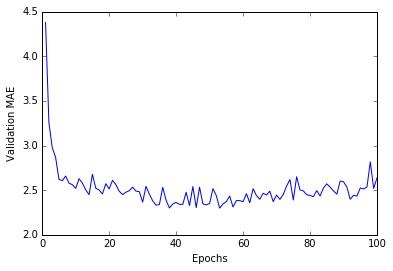

In [33]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

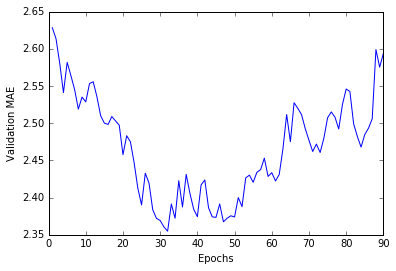

In [55]:
def smooth_curve(points, factor=0.7):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [51]:
model = build_model()
# Train it on the entirety of the data.
model.fit(X_train, y_train,
          epochs=50, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)

 32/102 [========>.....................] - ETA: 0s

In [52]:
test_mse_score, test_mae_score

(18.505070555443858, 2.7276975220324946)